首先导入必要的python包

注意：如果报错`缺失punkt`的话，把`nltk.download('punkt')`取消注释即可。

可能需要预先安装的包：

```bash
pip install vocabulary
pip install nltk
pip install -U requests                     # 这里是因为前面安装vocabulary包会导致requests起一些冲突，建议再安装一次
pip install rouge
```

In [1]:
import nltk
import os
import torch
import torch.utils.data as data
from vocabulary.vocabulary import Vocabulary
from PIL import Image
import numpy as np
from tqdm import tqdm
import random
import json
from collections import defaultdict, Counter
from PIL import Image
from matplotlib import pyplot as plt
import nltk

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 数据处理部分，分开处理训练集和测试集

In [2]:
%matplotlib inline
import os
import json
import random
from collections import defaultdict, Counter
from PIL import Image
from matplotlib import pyplot as plt

def create_dataset(dataset='deepfashion',
                   captions_per_image=1,
                   min_word_count=1,
                   max_len=80) -> str:
    """
    params:
        dataset: dataset path
        captions_per_image: captions amount for each image
        min_word_count: the minimum word count threshold
        max_len: max length of caption
    output:
        vocab.json
        train_data.json, val_data.json, test_data.json
    """ 
    train_data_json_path = '../dataset/deepfashion-multimodel/train_captions.json'
    test_data_json_path = '../dataset/deepfashion-multimodel/test_captions.json'
    image_folder = '../dataset/deepfashion-multimodel/images/'
    output_folder = '../output/' 
    
    # add additional check to avoid wasting time on processing dataset.
    if os.path.exists(output_folder):
        files = os.listdir(output_folder)
        if 'vocab.json' in files and 'train_data.json' in files and 'test_data.json' in files:
            print('Dataset already exists. Skipping processing.')
            return output_folder
    else:
        os.makedirs(output_folder)

    with open(train_data_json_path, 'r') as j:
        data = json.load(j)

    image_paths = []
    image_captions = []
    vocab = Counter()
    # push the captions into vocab
    for k,v in data.items():
        tokens = nltk.tokenize.word_tokenize(v.lower())
        vocab.update(tokens)
        path = os.path.join(image_folder,k)
        image_paths.append(path)
        if len(tokens) <= max_len:
            image_captions.append(tokens)
        elif len(tokens) > max_len:
            tokens=tokens[0:max_len]
            image_captions.append(tokens)
        if len(tokens) == 0:
            continue

    # create vocab
    words = [w for w in vocab.keys() if vocab[w] >= min_word_count]
    vocab = {k: v + 1 for v, k in enumerate(words)}
    vocab['<pad>'] = 0
    vocab['<unk>'] = len(vocab)
    vocab['<start>'] = len(vocab)
    vocab['<end>'] = len(vocab)

    # store vocab
    with open(os.path.join(output_folder, 'vocab.json'), 'w') as fw:
        json.dump(vocab, fw)

    # clean up captions
    enc_captions = []
    for j, c in enumerate(image_captions):
        # encode the captions according to vocab
        enc_c = [vocab['<start>']] + [vocab.get(word, vocab['<unk>']) for word in c] + [vocab['<end>']]
        enc_captions.append(enc_c)

    assert len(image_paths) * captions_per_image == len(enc_captions)

    for i, path in enumerate(image_paths):
        # check if the image can be resolved
        img = Image.open(path)

    
    data = {'IMAGES': image_paths,
            'CAPTIONS': enc_captions}
    with open(os.path.join(output_folder, 'train_data.json'), 'w') as fw:
        json.dump(data, fw)

    with open(test_data_json_path, 'r') as t:
        test_data = json.load(t)

    test_image_paths = []
    test_image_captions = []

    for k,v in test_data.items():
        tokens=nltk.tokenize.word_tokenize(v.lower())
        path = os.path.join(image_folder,k)
        test_image_paths.append(path)
        if len(tokens) <= max_len:
            test_image_captions.append(tokens)
        elif len(tokens) > max_len :
            tokens=tokens[0:max_len]
            test_image_captions.append(tokens)
        if len(tokens) == 0:
            continue

    test_enc_captions = []
    for j, c in enumerate(test_image_captions):
        enc_c = [vocab['<start>']] + [vocab.get(word, vocab['<unk>']) for word in c] + [vocab['<end>']]
        test_enc_captions.append(enc_c)


    assert len(image_paths) * captions_per_image == len(enc_captions)

    for i, path in enumerate(image_paths):
        img = Image.open(path)

    testdata = {'IMAGES': test_image_paths,
            'CAPTIONS': test_enc_captions}
    with open(os.path.join(output_folder, 'test_data.json'), 'w') as fw:
        json.dump(testdata, fw)
        
    return output_folder
output_folder = create_dataset()

Dataset already exists. Skipping processing.


对上方的数据集初步处理结果进行简单的验证

具体验证思路仿造案例：

随机读取图像、查看图像，查看图像对应的caption

[107, 1, 24, 26, 33, 69, 40, 29, 11, 12, 13, 14, 1, 40, 18, 29, 8, 9, 14, 17, 4, 33, 65, 15, 14, 1, 24, 26, 33, 5, 50, 14, 1, 50, 47, 29, 8, 9, 10, 58, 12, 13, 14, 51, 18, 27, 53, 35, 36, 54, 14, 23, 24, 18, 32, 33, 34, 35, 36, 37, 14, 108]
<start> the lady wears a short-sleeve shirt with solid color patterns . the shirt is with cotton fabric . it has a lapel neckline . the lady wears a long trousers . the trousers are with cotton fabric and pure color patterns . there is an accessory on her wrist . this lady is wearing a ring on her finger . <end>


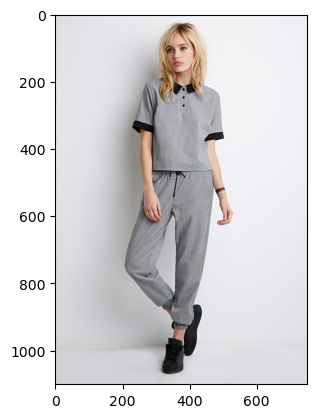

In [3]:
# read vocab and datas
with open(os.path.join(output_folder, 'vocab.json'), 'r') as f:
    vocab = json.load(f)
vocab_idx2word = {idx:word for word,idx in vocab.items()}
with open(os.path.join(output_folder, 'train_data.json'), 'r') as f:
    data = json.load(f)
with open(os.path.join(output_folder, 'test_data.json'), 'r') as k:
    testdata = json.load(k)

# show the 20th data
# show image
content_img = Image.open(data['IMAGES'][20])
plt.imshow(content_img)

# show token_ids and tokens
print(data['CAPTIONS'][20])
print(' '.join([vocab_idx2word[word_idx] for word_idx in data['CAPTIONS'][20]]))

构建dataset类，便于后续dataloader的构建

在此处，我们创建`ImageCaption` 数据集，`getitem`内部函数返回三个值：

+ image: PIL.Image
+ caption: str
+ cap_len: int

In [4]:
from argparse import Namespace
import numpy as np
import os
import json
from PIL import Image
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

class ImageCaptionDataset(Dataset):
    def __init__(self, 
                 dataset_path: str, 
                 vocab_path: str, 
                 split: str,    # the choice in {'train', 'test'}
                 captions_per_image: int=1, 
                 max_len: int=80, 
                 transform=None):
        self.split = split
        assert self.split in {'train', 'test'}
        self.cpi = captions_per_image
        self.max_len = max_len

        # load the json files
        with open(dataset_path, 'r') as f:
            self.data = json.load(f)
        with open(vocab_path, 'r') as f:
            self.vocab = json.load(f)

        # process the images for further forward computing
        self.transform = transform

        # Total number of data points
        self.dataset_size = len(self.data['CAPTIONS'])

    def __getitem__(self, i):
        # 第i个文本描述对应第(i // captions_per_image)张图片
        img = Image.open(self.data['IMAGES'][i]).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        caplen = len(self.data['CAPTIONS'][i])
        caption = torch.LongTensor(self.data['CAPTIONS'][i]+ [self.vocab['<pad>']] * (self.max_len + 2 - caplen))

        return img, caption, caplen


    def __len__(self):
        return self.dataset_size

仿：定义`mktrainval`函数，返回train_dataloader和test_dataloader

这一步需要使用上方的`ImageCaptionDataset`类

In [5]:
def mktrainval(data_dir, vocab_path, batch_size, workers=4):
    train_tx = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_tx = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_set = ImageCaptionDataset(os.path.join(data_dir, 'train_data.json'),
                                 vocab_path, 
                                 split='train',  
                                 transform=train_tx)
    test_set = ImageCaptionDataset(os.path.join(data_dir, 'test_data.json'),
                                 vocab_path, 
                                 split='test', 
                                 transform=val_tx)

    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True, drop_last=False)

    return train_loader, test_loader


### 编码器的self attention部分，采用多头注意力实现，添加在resnet101网络后

In [6]:
import torch
import torch.nn as nn
import torchvision

class SelfAttention(nn.Module):
    def __init__(self, embed_dim, heads):
        super(SelfAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=heads)
        
    def forward(self, feature_maps):
        """
        :param 
            feature_maps: torch.Tensor, shape (batch_size, channels, height, width)
            
        :return: torch.Tensor, shape (batch_size, channels, height, width)
        """
        
        # Reshape feature_maps to (batch_size, width*height, channels) for multihead attention
        batch_size, channels, height, width = feature_maps.size()
        feature_maps = feature_maps.permute(0, 2, 3, 1).reshape(batch_size, height * width, channels)
        # Calculate self-attention (it returns attn_output and attn_output_weights, but we need only the output)
        attn_output, _ = self.multihead_attn(feature_maps, feature_maps, feature_maps)
        # Reshape back to (batch_size, channels, height, width)
        attn_output = attn_output.reshape(batch_size, height, width, channels).permute(0, 3, 1, 2)
        return attn_output

从这里开始，基于前面的self-attention层，做一个基于注意力layer的encoder

In [7]:
# encoder for image, add attention layer
import torchvision.models as models
class ImageEncoder(nn.Module):
    def __init__(self, finetuned=True, heads=8, attn_embed_dim=2048):
        super(ImageEncoder, self).__init__()
        self.model = torchvision.models.resnet101(pretrained=True)  # we use pretrained ImageNet ResNet-101        
        self.grid_rep_extractor = nn.Sequential(*(list(self.model.children())[:-2]))    # ResNet Conv as grid extractor

        self.self_attention = SelfAttention(embed_dim=attn_embed_dim, heads=heads)
        
        for param in self.grid_rep_extractor.parameters():
            param.requires_grad = finetuned
            
    def forward(self, images):
        feature_maps = self.grid_rep_extractor(images)  # (batch_size, 2048, H, W)
        #feature_maps = self.additional_conv(feature_maps)  # (batch_size, attn_embed_dim, H, W)
        out = self.self_attention(feature_maps)
        return out

### 下面三块是解码器和整体网络搭建

In [8]:
class AdditiveAttention(nn.Module):
    def  __init__(self, query_dim, key_dim, attn_dim):
        super(AdditiveAttention, self).__init__()
        self.attn_w_1_q = nn.Linear(query_dim, attn_dim)
        self.attn_w_1_k = nn.Linear(key_dim, attn_dim)
        self.attn_w_2 = nn.Linear(attn_dim, 1)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, query, key_value):
        """
        shape: 
            query: (batch_size, q_dim)  ===================> Q
            key_value: (batch_size, n_kv, kv_dim) =======> K, V
        """
        
        queries = self.attn_w_1_q(query).unsqueeze(1)               # -> (batch_size, 1, attn_dim)
        keys = self.attn_w_1_k(key_value)                           # -> (batch_size, n_kv, attn_dim)
        attn = self.attn_w_2(self.tanh(queries+keys)).squeeze(2)    # -> (batch_size, n_kv)
        # normalize weights
        attn = self.softmax(attn)                                   # -> (batch_size, n_kv)
        # get the attn output
        
        output = torch.bmm(attn.unsqueeze(1), key_value).squeeze(1) # -> (batch_size, 1, kv_dim)
        return output, attn

In [9]:
class AttentionDecoder(nn.Module):
    def __init__(self, feature_dim, vocab_size, word_dim, attention_dim, hidden_size, num_layers, dropout=0.5):
        super(AttentionDecoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, word_dim)
        self.attention = AdditiveAttention(hidden_size, feature_dim, attention_dim)
        self.init_state = nn.Linear(feature_dim, num_layers*hidden_size)
        self.rnn = nn.GRU(word_dim + feature_dim, hidden_size, num_layers)
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
        self.init_weights()

    def init_weights(self):
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, image_feature, captions, cap_lens):
        """
            image_feature: the image feature extracted by CNN, 
                            shape (batch_size, feature_dim, grid_height, grid_width)

        """
        # convert image_feature to (batch_size, feature_dim, grid_height*grid_width)
        batch_size, feature_dim = image_feature.size(0), image_feature.size(1)
        # switch the order of grid_height and grid_width
        image_feature = image_feature.permute(0, 2, 3, 1)
        # flatten the feature maps
        image_feature = image_feature.view(batch_size, -1, feature_dim)
        # sort the captions by their lengths
        sorted_cap_lens, sorted_cap_indices = torch.sort(cap_lens, 0, True)
        captions = captions[sorted_cap_indices]
        image_feature = image_feature[sorted_cap_indices]
        
        # get the initial hidden state
        hidden_state = self.init_state(image_feature.mean(axis=1))
        hidden_state = hidden_state.view(
                            batch_size,
                            self.rnn.num_layers,
                            self.rnn.hidden_size).permute(1, 0, 2)
        return image_feature, captions, sorted_cap_lens, sorted_cap_indices, hidden_state

    def forward_step(self, image_feature, curr_cap_embed, hidden_state):
        context, alpha = self.attention(hidden_state[-1], image_feature)
        # (1, real_batch_size, hidden_size+word_dim)
        x = torch.cat((context, curr_cap_embed), dim=-1).unsqueeze(0)
        # x: (1, real_batch_size, hidden_size+word_dim)
        # out: (1, real_batch_size, hidden_size)
        out, hidden_state = self.rnn(x, hidden_state)
        preds = self.fc(self.dropout(out.squeeze(0)))
        return preds, alpha, hidden_state

    def forward(self, image_feature, captions, cap_lens):
        """
            hidden_state: (num_layers, batch_size, hidden_size)
            image_feature:  (batch_size, feature_channel, feature_size)
            captions: (batch_size, )
        """
        image_feature, captions, sorted_cap_lens, sorted_cap_indices, hidden_state \
            = self.init_hidden_state(image_feature, captions, cap_lens)
        batch_size = image_feature.size(0)
        
        # notice: the input length -1, because we don't need to predict the last word
        lengths = sorted_cap_lens.cpu().numpy() - 1

        predictions = torch.zeros(batch_size, lengths[0], self.fc.out_features).to(captions.device)
        alphas = torch.zeros(batch_size, lengths[0], image_feature.shape[1]).to(captions.device)
        # cap_embeds: (batch_size, num_steps, word_dim)
        cap_embeds = self.embed(captions)
        # Teacher-Forcing
        for step in range(lengths[0]):
            real_batch_size = np.where(lengths>step)[0].shape[0]
            preds, alpha, hidden_state = self.forward_step(
                            image_feature[:real_batch_size],
                            cap_embeds[:real_batch_size, step, :],
                            hidden_state[:, :real_batch_size, :].contiguous())

            predictions[:real_batch_size, step, :] = preds
            alphas[:real_batch_size, step, :] = alpha
        return predictions, alphas, captions, lengths, sorted_cap_indices

In [10]:
class ARCTIC(nn.Module):
    def __init__(self, image_code_dim, vocab, word_dim, attention_dim, hidden_size, num_layers):
        super(ARCTIC, self).__init__()
        self.vocab = vocab
        self.encoder = ImageEncoder()
        self.decoder = AttentionDecoder(image_code_dim, len(vocab), word_dim, attention_dim, hidden_size, num_layers)

    def forward(self, images, captions, cap_lens):
        image_code = self.encoder(images)
        return self.decoder(image_code, captions, cap_lens)

    def generate(self, images, beam_k, max_len):
        vocab_size = len(self.vocab)
        image_codes = self.encoder(images)
        texts = []
        device = images.device
        
        # beamsearch for each image
        for image_code in image_codes:
            gen_sent = self._beam_search(image_code, beam_k, max_len, vocab_size)
            texts.append(gen_sent)
        return texts
    
    def _beam_search(self, image_code, beam_k, max_len, vocab_size):
        # make `k` copies for a image
        image_code = image_code.unsqueeze(0).repeat(beam_k,1,1,1)       #  (5，2048)
        # generate k sentences
        cur_sents = torch.full((beam_k, 1), self.vocab['<start>'], dtype=torch.long).to(device)
        cur_sent_embed = self.decoder.embed(cur_sents)[:,0,:]
        sent_lens = torch.LongTensor([1]*beam_k).to(device)

        image_code, cur_sent_embed, _, _, hidden_state = \
            self.decoder.init_hidden_state(image_code, cur_sent_embed, sent_lens)

        # store generated sentences
        end_sentences = []
        end_probs = []
        probs = torch.zeros(beam_k, 1).to(device)
        k = beam_k
        while True:
            preds, _, hidden_state = self.decoder.forward_step(image_code[:k], cur_sent_embed, hidden_state.contiguous())
            preds = nn.functional.log_softmax(preds, dim=1)

            probs = probs.repeat(1,preds.size(1)) + preds
            if cur_sents.size(1) == 1:
                values, indices = probs[0].topk(k, 0, True, True)
            else:
                # convert to 1D
                values, indices = probs.view(-1).topk(k, 0, True, True)

            sent_indices = torch.div(indices, vocab_size, rounding_mode='trunc')
            word_indices = indices % vocab_size

            cur_sents = torch.cat([cur_sents[sent_indices], word_indices.unsqueeze(1)], dim=1)

            end_indices = [idx for idx, word in enumerate(word_indices) if word == self.vocab['<end>']]
            if len(end_indices) > 0:
                end_probs.extend(values[end_indices])
                end_sentences.extend(cur_sents[end_indices].tolist())

                k -= len(end_indices)
                if k == 0:
                    break

            cur_indices = [idx for idx, word in enumerate(word_indices)
                            if word != self.vocab['<end>']]
            if len(cur_indices) > 0:
                cur_sent_indices = sent_indices[cur_indices]
                cur_word_indices = word_indices[cur_indices]

                cur_sents = cur_sents[cur_indices]
                probs = values[cur_indices].view(-1,1)
                hidden_state = hidden_state[:,cur_sent_indices,:]
                cur_sent_embed = self.decoder.embed(
                    cur_word_indices.view(-1,1))[:,0,:]

            if cur_sents.size(1) >= max_len:
                break
        if len(end_sentences) == 0:
            generate_sentence = cur_sents[0].tolist()
        else:
            generate_sentence = end_sentences[end_probs.index(max(end_probs))]
            
        return generate_sentence


In [11]:
class CrossEntropyLoss(nn.Module):
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, predictions, targets, lengths):
        predictions = pack_padded_sequence(predictions, lengths, batch_first=True)[0]
        targets = pack_padded_sequence(targets, lengths, batch_first=True)[0]
        return self.loss_fn(predictions, targets)


In [12]:
def get_optimizer(model, config):
    return torch.optim.Adam([{"params": filter(lambda p: p.requires_grad, model.encoder.parameters()),
                              "lr": config.encoder_learning_rate},
                             {"params": filter(lambda p: p.requires_grad, model.decoder.parameters()),
                              "lr": config.decoder_learning_rate}])

def adjust_learning_rate(optimizer, epoch, config):
    optimizer.param_groups[0]['lr'] = config.encoder_learning_rate * (0.1 ** (epoch // config.lr_update))
    optimizer.param_groups[1]['lr'] = config.decoder_learning_rate * (0.1 ** (epoch // config.lr_update))

In [13]:
from nltk.translate.bleu_score import corpus_bleu

def filter_useless_words(sent, filterd_words):

    return [w for w in sent if w not in filterd_words]

def evaluate_belu4(data_loader, model, config, eval_rate=1.0):
    model.eval()
    cands = []
    refs = []
    filterd_words = set({model.vocab['<start>'], model.vocab['<end>'], model.vocab['<pad>']})
    cpi = config.captions_per_image
    device = next(model.parameters()).device
    eval_length = eval_rate * len(data_loader)
    for i, (imgs, caps, caplens) in enumerate(data_loader):
        if i >= eval_length:
            break
        with torch.no_grad():
            texts = model.generate(imgs.to(device), config.beam_k, config.max_len+2)
            cands.extend([filter_useless_words(text, filterd_words) for text in texts])
            refs.extend([filter_useless_words(cap, filterd_words) for cap in caps.tolist()])
    multiple_refs = []
    for idx in range(len(refs)):
        multiple_refs.append(refs[(idx//cpi)*cpi : (idx//cpi)*cpi+cpi])
    bleu4 = corpus_bleu(multiple_refs, cands, weights=(0.25,0.25,0.25,0.25))
    model.train()
    return bleu4

In [14]:
import json
import torch
from nltk.translate.meteor_score import single_meteor_score

def evaluate_meteor(data_loader, model, config, eval_rate=1.0):
    model.eval()
    cands = []
    refs = []
    filterd_words = set({'<start>', '<end>', '<pad>'})
    device = next(model.parameters()).device

    with open(os.path.join(output_folder, 'vocab.json'), 'r') as f:
        vocab = json.load(f)
    vocab_idx2word = {idx: word for word, idx in vocab.items()}
    
    eval_length = eval_rate * len(data_loader)
    
    for i, (imgs, caps, caplens) in enumerate(data_loader):
        if i >= eval_length:
            break
        with torch.no_grad():
            texts = model.generate(imgs.to(device), config.beam_k, config.max_len+2)
            decoded_texts = [' '.join([vocab_idx2word[word_idx] for word_idx in text]) for text in texts]
            filtered_texts = [' '.join(filter_useless_words(text.split(), filterd_words)) for text in decoded_texts]
            cands.extend(filtered_texts)
            
            for cap in caps.tolist():
                decoded_cap = ' '.join([vocab_idx2word[word_idx] for word_idx in cap if word_idx in vocab_idx2word])
                filtered_cap = ' '.join(filter_useless_words(decoded_cap.split(), filterd_words))
                refs.append(filtered_cap)

    meteor_score = 0
    for cand, ref in zip(cands, refs):
        meteor_score += single_meteor_score(ref.split(), cand.split())

    meteor_score /= len(cands)
    model.train()
    return meteor_score

In [15]:
from rouge import Rouge

def evaluate_Rouge_L(data_loader, model, config, eval_rate=1.0):
    model.eval()
    cands = []
    refs = []
    decoded_caps = []
    filterd_words = set({'<start>', '<end>', '<pad>'})
    device = next(model.parameters()).device

    with open(os.path.join(output_folder, 'vocab.json'), 'r') as f:
        vocab = json.load(f)
    vocab_idx2word = {idx: word for word, idx in vocab.items()}
    
    eval_length = eval_rate * len(data_loader)

    for i, (imgs, caps, caplens) in enumerate(data_loader):
        if i >= eval_length:
            break
        with torch.no_grad():
            texts = model.generate(imgs.to(device), config.beam_k, config.max_len+2)
            decoded_texts = [' '.join([vocab_idx2word[word_idx] for word_idx in text]) for text in texts]
            filtered_texts = [' '.join(filter_useless_words(text.split(), filterd_words)) for text in decoded_texts]
            cands.extend(filtered_texts)
            
            for cap in caps.tolist():
                decoded_cap = ' '.join([vocab_idx2word[word_idx] for word_idx in cap if word_idx in vocab_idx2word])
                filtered_cap = ' '.join(filter_useless_words(decoded_cap.split(), filterd_words))
                refs.append(filtered_cap)

    rouge_evaluator = Rouge(metrics=['rouge-l'])

    scores = rouge_evaluator.get_scores(cands, refs, avg=True) 
    rouge_l_score = scores['rouge-l']['f']  

    model.train()
    return rouge_l_score

### 下面是训练部分

In [16]:
from tqdm import tqdm

# 设置模型超参数和辅助变量
config = Namespace(
    max_len = 80,
    captions_per_image = 1,
    batch_size = 32,
    image_code_dim = 2048,
    word_dim = 512,
    hidden_size = 512,
    attention_dim = 512,
    num_layers = 1,
    encoder_learning_rate = 0.001,
    decoder_learning_rate = 0.0005,
    num_epochs = 3,
    grad_clip = 5.0,
    alpha_weight = 1.0,
    evaluate_step = 300, 
    checkpoint = None, 
    beam_k = 5
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

data_dir = output_folder
vocab_path = os.path.join(data_dir, 'vocab.json')
train_loader, test_loader = mktrainval(data_dir, vocab_path, config.batch_size)

with open(vocab_path, 'r') as f:
    vocab = json.load(f)

start_epoch = 0
checkpoint = config.checkpoint
if checkpoint is None:
    model = ARCTIC(config.image_code_dim, vocab, config.word_dim, config.attention_dim, config.hidden_size, config.num_layers)
else:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    model = checkpoint['model']

optimizer = get_optimizer(model, config)

model.to(device)
model.train()

loss_fn = CrossEntropyLoss().to(device)

ckpt_path = os.path.join(output_folder, 'model_ckpt/attn')

if not os.path.exists(ckpt_path):
    os.makedirs(ckpt_path)

best_res = 0
print("Start training")

epochs = [3, 5, 7, 10]

for epoch in range(start_epoch, config.num_epochs):
    print("Training on epoch ", epoch)
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{config.num_epochs}', unit='batch') as pbar:
        for i, (imgs, caps, caplens) in enumerate(train_loader):
            optimizer.zero_grad()

            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

            predictions, alphas, sorted_captions, lengths, sorted_cap_indices = model(imgs, caps, caplens)

            loss = loss_fn(predictions, sorted_captions[:, 1:], lengths)
            loss += config.alpha_weight * ((1. - alphas.sum(axis=1)) ** 2).mean()

            loss.backward()
            if config.grad_clip > 0:
                nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)


            optimizer.step()
            
            pbar.update(1)
            pbar.set_postfix(loss=loss.item())

            if (i+1) % 50 == 0:
                print('epoch %d, step %d: loss=%.2f' % (epoch, i+1, loss.cpu()))

            state = {
                    'epoch': epoch,
                    'step': i,
                    'model': model,
                    'optimizer': optimizer
                    }
            # save model weights for current and best
            if (i+1) % config.evaluate_step == 0:        

                print("Validating on test set")
                bleu_score = evaluate_belu4(test_loader, model, config, eval_rate=0.5)
                if best_res < bleu_score:
                    best_res = bleu_score
                    torch.save(model.state_dict(), os.path.join(ckpt_path, 'best_ARCTIC.pth'))
                torch.save(model.state_dict(), os.path.join(ckpt_path, 'current_model.pth'))
                print('Validation@epoch, %d, step, %d, BLEU-4=%.2f' %
                    (epoch, i+1, bleu_score))
        
print("========================= BELU EVALUATE ==============================")
model.load_state_dict(torch.load(os.path.join(ckpt_path, 'best_ARCTIC.pth')))
model.eval()
bleu_score = evaluate_belu4(test_loader, model, config)

print("Evaluate on the test set with the model that has the best performance on the validation set")
print('Epoch: 1, BLEU-4=%.2f' % bleu_score)


cuda


/home/airaiot/miniconda3/envs/adapter/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/airaiot/miniconda3/envs/adapter/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Start training
Training on epoch  0


Epoch 1/3:  16%|█▌        | 51/318 [00:12<00:58,  4.58batch/s, loss=2.35]

epoch 0, step 50: loss=2.35


Epoch 1/3:  30%|███       | 96/318 [00:22<00:52,  4.22batch/s, loss=1.14]


KeyboardInterrupt: 

### 结果验证，选取了测试集的第一张照片作为输入，用网络的beamsearch函数寻找概率最高的句子，并用构建的词表vocab解码

In [17]:
import torchvision.transforms as transforms
nltk.download('wordnet')

model = ARCTIC(config.image_code_dim, vocab, config.word_dim, config.attention_dim, config.hidden_size, config.num_layers)
model.load_state_dict(torch.load(os.path.join(ckpt_path, 'best_ARCTIC.pth')))

model = model.to(device)
model.eval()

with open(os.path.join(output_folder, 'vocab.json'), 'r') as f:
    vocab = json.load(f)
vocab_idx2word = {idx:word for word,idx in vocab.items()}

with open(os.path.join(output_folder, 'test_data.json'), 'r') as t:
    test = json.load(t)
img = Image.open(test['IMAGES'][0]).convert('RGB')
plt.imshow(img)
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
img = transform(img).unsqueeze(0)

img = img.to(device)

with torch.no_grad():
    generated_text=model.generate(img,5,80)
print("generated text is",generated_text)
for text in generated_text:
    print("decode text is",' '.join([vocab_idx2word[word_idx] for word_idx in text]))
    
meteor_score = evaluate_meteor(test_loader, model, config)
rouge_l_score = evaluate_Rouge_L(test_loader, model, config)

print('METEOR=%.2f' % meteor_score)
print('ROUGE-L=%.2f' % rouge_l_score)


KeyboardInterrupt: 